# Read in the data

First I am creating an array containing the school data files to open and then loop through opening them and eliminating the .csv so it is easier to call them later. 

In [126]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(f)
    data[f.replace(".csv", "")] = d

# Read in the surveys

Most of the school survey content is in 'all_survey', however one school district is contained in 'd75_survey'. Since the format of either survey is identical, I'll read these two survey datasets in and then combine them. I'll also rename the 'dbn' column to 'DBN'. 

In [127]:
all_survey = pd.read_csv('survey_all.csv', delimiter=",", encoding='windows-1252')
d75_survey = pd.read_csv('survey_d75.csv', delimiter=",", encoding='windows-1252')


survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

# checking for accuracy
survey.info()
survey.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2768 entries, dbn to s_q14_11
dtypes: float64(2761), int64(5), object(2)
memory usage: 36.0+ MB


,dbn,schoolname,rr_s,rr_t,rr_p,N_s,N_t,N_p,nr_s,nr_t,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,P.S. 015 Roberto Clemente,NaN,88,60,NaN,22.0,90.0,0,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,P.S. 019 Asher Levy,NaN,100,60,NaN,34.0,161.0,0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,P.S. 020 Anna Silver,NaN,88,73,NaN,42.0,367.0,0,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,P.S. 034 Franklin D. Roosevelt,89.0,73,50,145.0,29.0,151.0,163,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,P.S. 063 William McKinley,NaN,100,60,NaN,23.0,90.0,0,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the data dictionary for the survey, I feel that there is a lot of information that I just don't need. I'm going to remove a large number of the fields and keep only the relevant information for my data analysis.

In [128]:
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Data Cleaning

## Adding DBN columns

The 'hs_directory' dataset needs the 'dbn' column also changed to 'DBN.' The 'class_size' dataset needs a 'DBN' column added. It already has a column named 'csd' which stands for 'Community School District', and a column named 'School Code'. To give them a unique DBN, I'll combine the 'CSD' and 'School Code' identifiers to form a unique DBN. 

In [129]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In the 'sat_results' dataset some of the entries are non numeric and need to be converted. Also, I can create an actual SAT Score column from this data and add it to the dataset. 

In [130]:
data['sat_results'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


In [131]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

## Isolating the Latitude and Longitude data
The latitude and longitude data is contained in the field that also has the school's address. I need to extract this data and create new longitute and latitude columns.

In [132]:

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condensing datasets


In the 'class_size' dataset, there are multiple rows for the same school. Each school has a separat entry for 'grade' and 'program type'. I need to restrict each field to a single value. This could interfere with total class_size however; I'll fix that by computing class_size averages for each school and using that average.

In [133]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

 The 'demographics' dataset contains rows for multiple years for the same school. I'll just pick the most recent school year  for each set.

In [134]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

Same issue with the 'graduation' dataset. I'll just pick one cohort year: 2006. 

In [135]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

The 'ap_2010' dataset contains some information as strings which should be numeric. I'll convert them to numeric data.

In [136]:
data['ap_2010'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
DBN                                     258 non-null object
SchoolName                              258 non-null object
AP Test Takers                          233 non-null float64
Total Exams Taken                       233 non-null float64
Number of Exams with scores 3 4 or 5    151 non-null float64
dtypes: float64(3), object(2)
memory usage: 10.2+ KB


In [137]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets
I'll be combining the datasets using 'DBN' as the unique identifier. 

In [138]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping
adding a school district will assist with my data analysis later on.

In [139]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

I wanted to check the correlations so that I can refer back to them when doing further analysis and visualization.

In [140]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE  

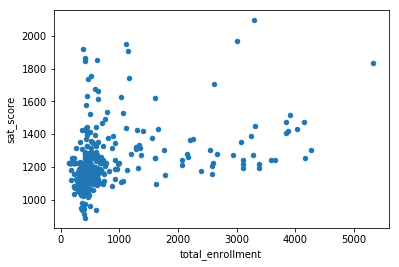

In [141]:
%matplotlib inline 
combined.plot.scatter(x='total_enrollment', y='sat_score')

C:\Users\Geoff\Anaconda3\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Text(0, 0.5, 'sat_score')

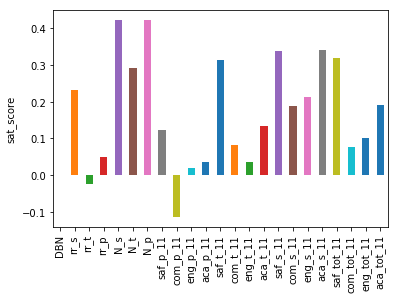

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
combined.corr().loc['sat_score', survey_fields].plot.bar()
plt.ylabel('sat_score')

# Burough Property Values

I would like to know which neighborhoods have the best schools. In order to do that, I'll read in a dataset containing property values in NYC, which I found at https://www.kaggle.com/new-york-city/nyc-property-sales#nyc-rolling-sales.csv.

In [143]:
properties = pd.read_csv('nyc-rolling-sales.csv')
data['properties'.replace('.csv','')] = properties

print(data['properties'].columns)
data['properties'].head()
data['properties'].describe()

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')


,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,10344.359878,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,1789.322976,1.657485
std,7151.779436,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,537.344993,0.819341
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4231.000000,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000
50%,8942.000000,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000
75%,15987.250000,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000
max,26739.000000,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000


#### Replacing burough numerical values with names.


In [144]:
boroughs = {
            '1': 'Manhattan',
            '2': 'The Bronx',
            '3': 'Brooklyn',
            '4': 'Queens',
            '5': 'Staten Island'
            }

def number2borough(number):
    return boroughs[str(number)]

data['properties']['BOROUGH'] = data['properties']['BOROUGH'].apply(number2borough)

#### I want to see the Neighborhoods based on property valuation. I'll explore the 'SALE PRICE' column:

In [145]:
data['properties']['SALE PRICE'].value_counts()

 -           14561
0            10228
10             766
450000         427
550000         416
650000         414
600000         409
700000         382
400000         378
750000         377
300000         351
500000         350
350000         345
800000         331
900000         324
250000         314
850000         309
950000         301
1100000        298
1200000        286
1300000        271
425000         265
475000         259
525000         259
325000         249
480000         233
1250000        229
625000         224
200000         223
460000         222
             ...  
14000            1
1207500          1
2981792          1
5620838          1
624166           1
8298737          1
223750           1
7567299          1
720411           1
1352643          1
570387           1
34623250         1
731615           1
1480447          1
612950           1
3895000          1
424100           1
57500            1
155695           1
360571           1
2351250          1
1017887     

####  There are a significant number of property values with a sale price of  0 or 10 which does not make sense for my analysis. I'll get rid of these

In [146]:
data['properties']['SALE PRICE'] = pd.to_numeric(data['properties']['SALE PRICE'], errors='coerce')
data['properties'] = data['properties'][data['properties']['SALE PRICE'] > 10]

data['properties']['SALE PRICE'].value_counts()

450000.0      427
550000.0      416
650000.0      414
600000.0      409
700000.0      382
400000.0      378
750000.0      377
300000.0      351
500000.0      350
350000.0      345
800000.0      331
900000.0      324
250000.0      314
850000.0      309
950000.0      301
1100000.0     298
1200000.0     286
1300000.0     271
425000.0      265
475000.0      259
525000.0      259
325000.0      249
480000.0      233
1250000.0     229
625000.0      224
200000.0      223
460000.0      222
430000.0      217
420000.0      217
375000.0      214
             ... 
820482.0        1
700500.0        1
227136.0        1
689399.0        1
6562339.0       1
3805492.0       1
3019101.0       1
2232717.0       1
1728000.0       1
1771744.0       1
885876.0        1
3543510.0       1
558200.0        1
13513488.0      1
689310.0        1
1017000.0       1
249161.0        1
60893873.0      1
558259.0        1
12200000.0      1
106500.0        1
2495221.0       1
81600.0         1
344682.0        1
344683.0  

In [147]:
data['properties'].to_csv('properties.csv')
data['properties'].to_excel('properties.xlsx')

Text(0, 0.5, 'SALE PRICE ($)')

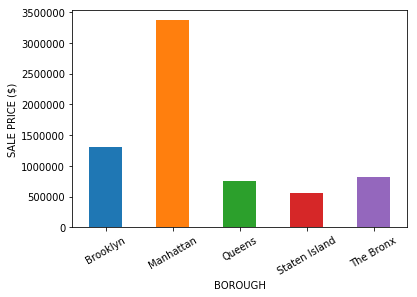

In [148]:
data['properties'] = data['properties'].groupby('BOROUGH').agg(numpy.mean)
data['properties'].reset_index(inplace=True)

data['properties'].plot.bar(x='BOROUGH', y='SALE PRICE', rot=30, legend=False)
plt.ylabel('SALE PRICE ($)')

#### exporting files to csv and excel

In [149]:
combined.to_csv('combined.csv')
combined.to_excel('combined.xlsx')